# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.transform import TrimAfterTrigger, apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  4000


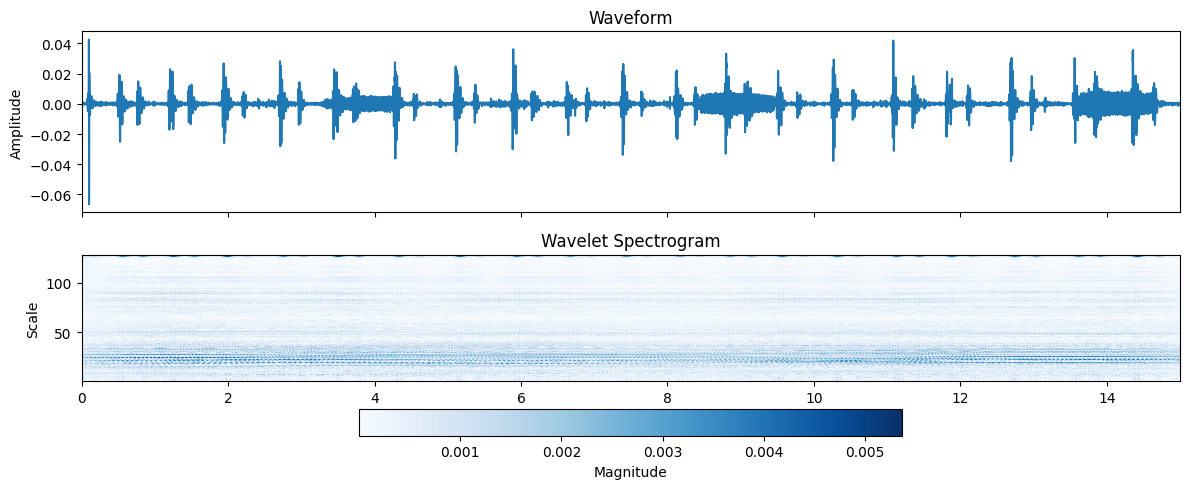

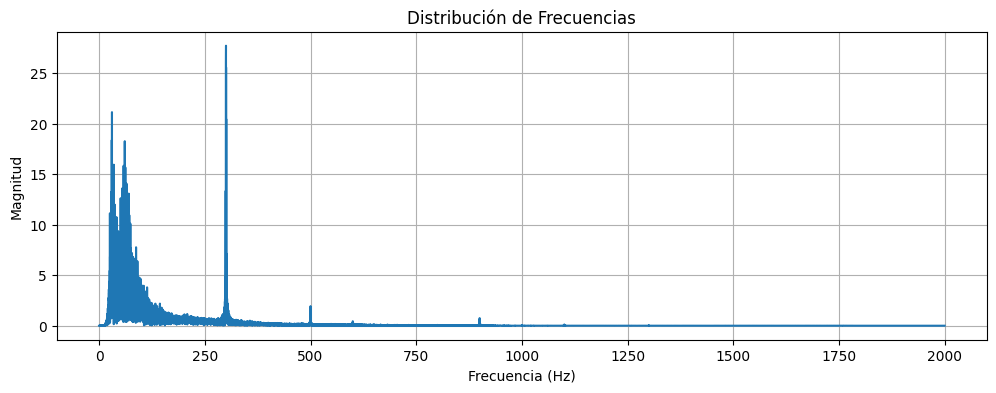

In [2]:
AUDIO_NAME = "test-202407211616.wav"
DIGITAL_AUDIO_DIR = get_base_dir().joinpath(f"data/digital/{AUDIO_NAME}")

digital_audio, digital_sample_rate = torchaudio.load(str(DIGITAL_AUDIO_DIR))
print("Sample rate: ", digital_sample_rate)

plot_wavelet_spectrogram(digital_audio.numpy(), digital_sample_rate)
plot_audio_fft(digital_audio.numpy(), digital_sample_rate)

Audio(digital_audio, rate=digital_sample_rate, autoplay=True)

# Focus on synthetic frequency

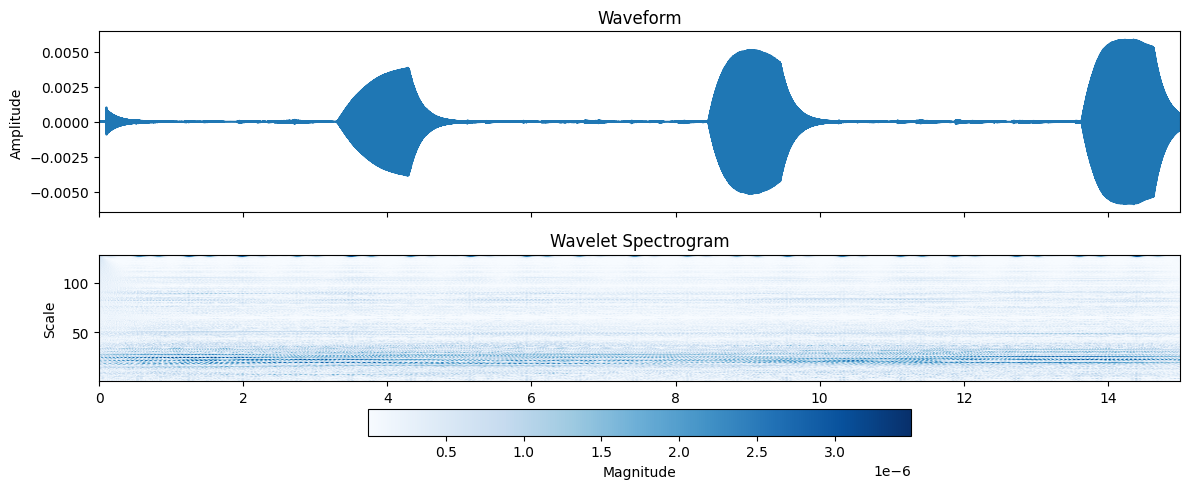

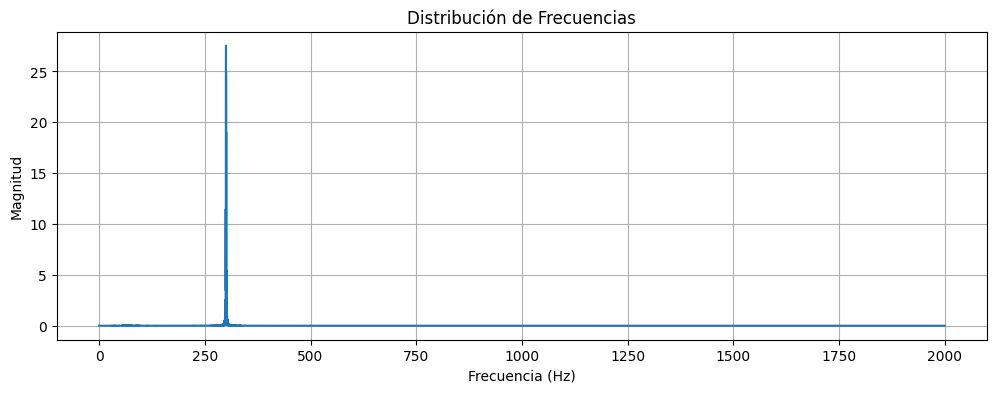

In [3]:
SYNTHETIC_FREQ = 300
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(
    digital_audio, digital_sample_rate, low_cutoff, high_cutoff
)

plot_wavelet_spectrogram(filtered_audio.numpy(), digital_sample_rate)
plot_audio_fft(filtered_audio.numpy(), digital_sample_rate)

Audio(filtered_audio, rate=digital_sample_rate, autoplay=True)

# Downsample and smooth it

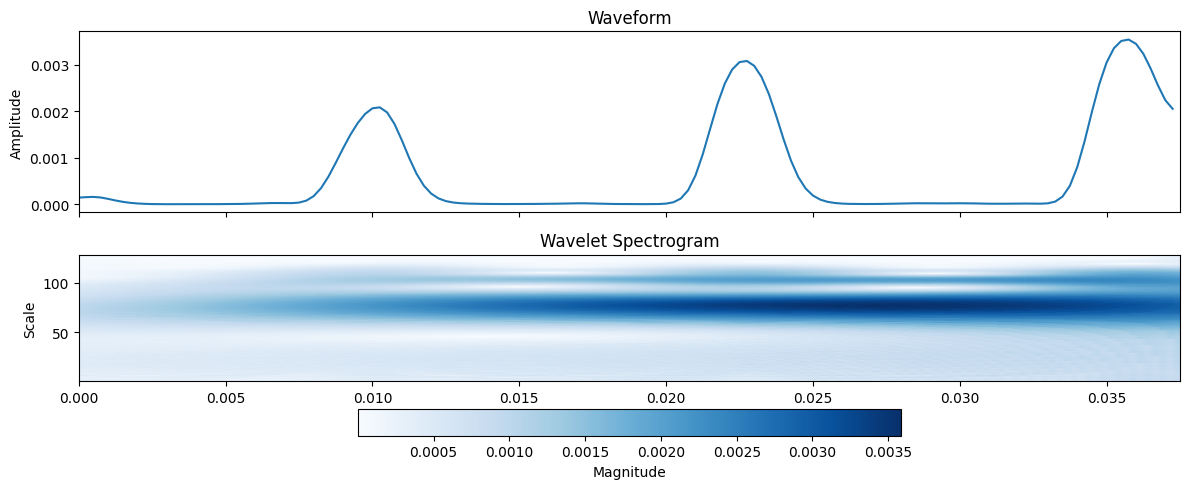

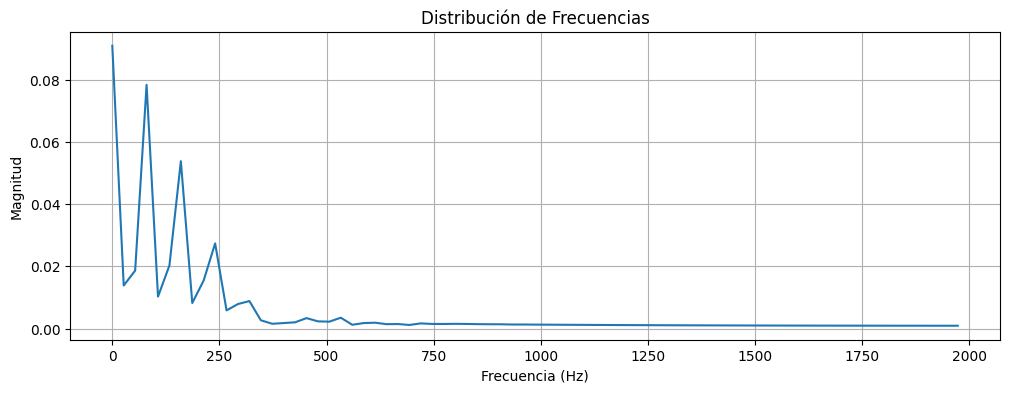

In [4]:
tat = TrimAfterTrigger()
DOWNSAMPLE_FACTOR = 400
SIGMA_SMOOTH = 2

smoothed = tat.abs_downsample_smooth(filtered_audio, DOWNSAMPLE_FACTOR, SIGMA_SMOOTH)
plot_wavelet_spectrogram(smoothed, digital_sample_rate, downsample_factor=1)
plot_audio_fft(smoothed, digital_sample_rate)

Audio(smoothed, rate=digital_sample_rate / DOWNSAMPLE_FACTOR, autoplay=True)

# Find peaks where signal changes

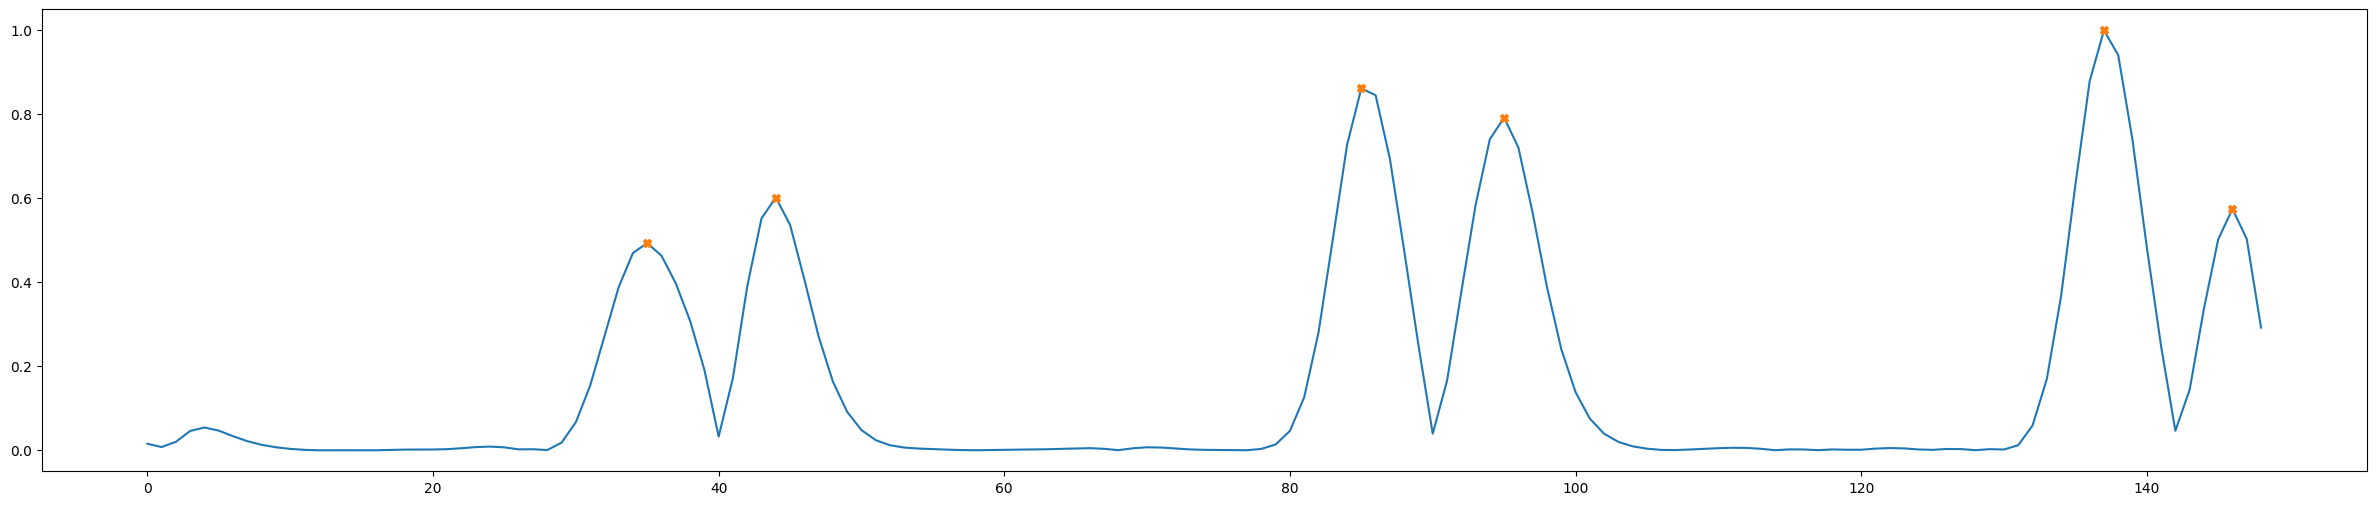

In [5]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(30, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

In [6]:
peaks

array([ 35,  44,  85,  95, 137, 146])

# Upsample those peaks in the raw audio signal

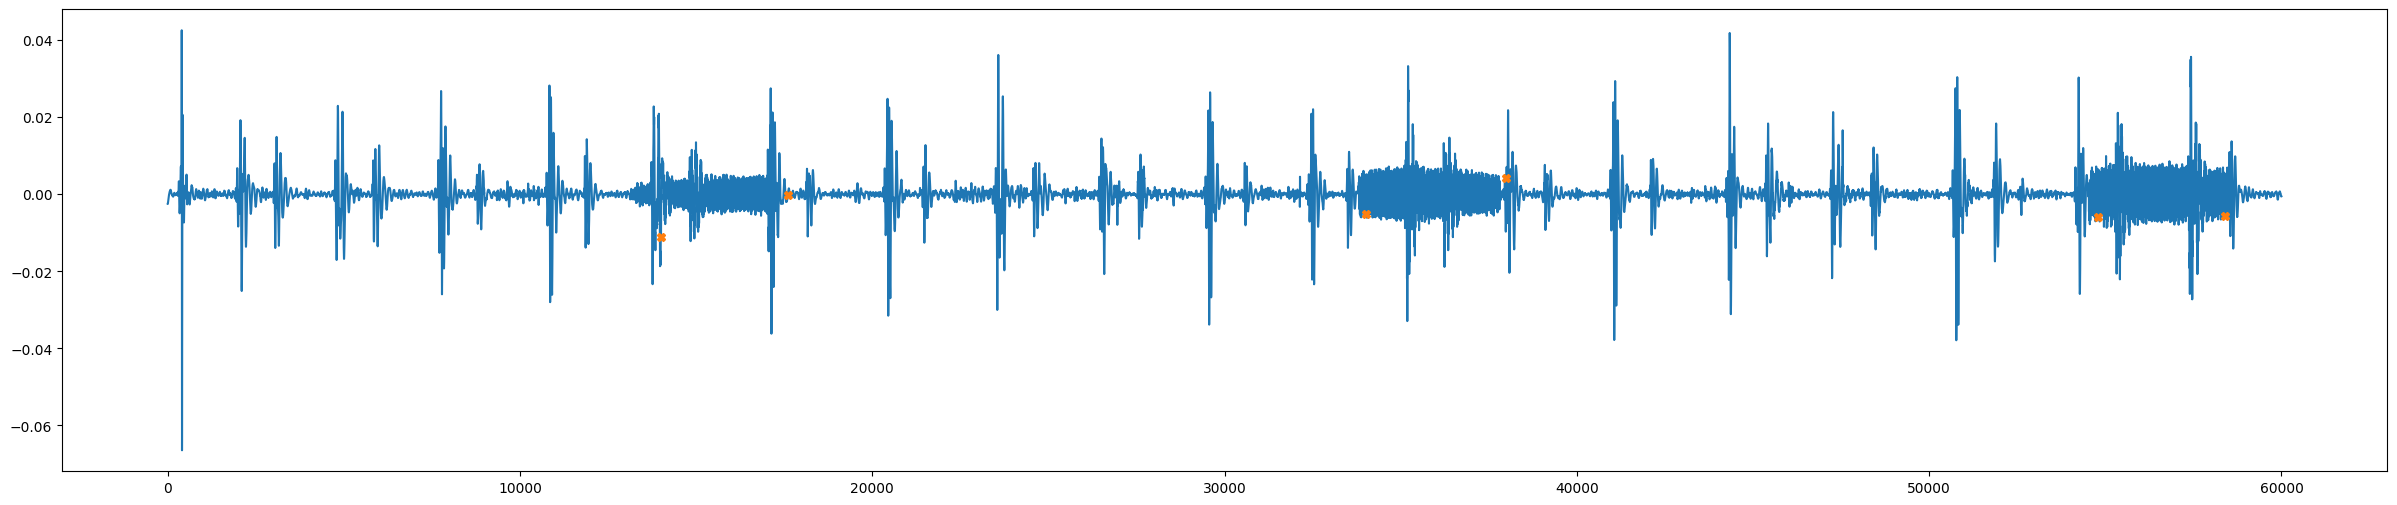

In [7]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR

plt.figure(figsize=(30, 6))
plt.plot(digital_audio.squeeze())
plt.plot(upsampled_peaks, digital_audio.squeeze()[upsampled_peaks], "X")

# Split signal

In [8]:
split_points = np.concatenate(([0], upsampled_peaks, [digital_audio.shape[1]]))

audio_tensor = digital_audio.squeeze()
segments = [
    audio_tensor[split_points[i] : split_points[i + 1]]
    for i in range(len(split_points) - 1)
]

for i, segment in enumerate(segments):
    duration = len(segment) / digital_sample_rate
    print(f"#{i+1} ({duration}s): {segment}")

#1 (3.5s): tensor([-0.0025, -0.0025, -0.0025,  ..., -0.0097, -0.0103, -0.0109])
#2 (0.9s): tensor([-0.0112, -0.0109, -0.0099,  ..., -0.0005, -0.0005, -0.0004])
#3 (4.1s): tensor([-3.0518e-04, -1.8311e-04, -6.1035e-05,  ...,  7.0190e-04,
        -1.5259e-03, -3.7231e-03])
#4 (1.0s): tensor([-0.0050, -0.0049, -0.0037,  ...,  0.0004,  0.0018,  0.0031])
#5 (4.2s): tensor([ 0.0041,  0.0049,  0.0055,  ...,  0.0021, -0.0008, -0.0038])
#6 (0.9s): tensor([-0.0058, -0.0062, -0.0054,  ...,  0.0010, -0.0015, -0.0040])
#7 (0.4s): tensor([-0.0057, -0.0061, -0.0054,  ..., -0.0005, -0.0005, -0.0005])


# Keep just the valid segments

#1 (4.1s): tensor([-3.0518e-04, -1.8311e-04, -6.1035e-05,  ...,  7.0190e-04,
        -1.5259e-03, -3.7231e-03])


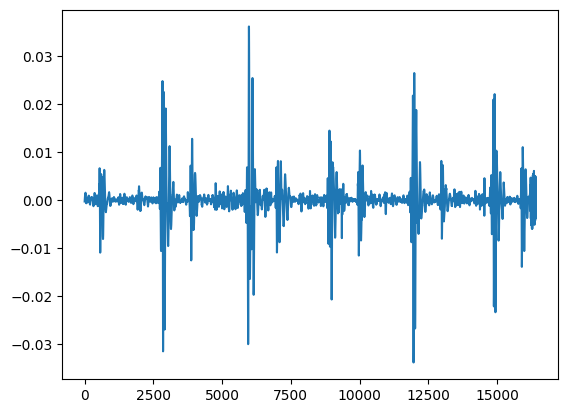

#2 (4.2s): tensor([ 0.0041,  0.0049,  0.0055,  ...,  0.0021, -0.0008, -0.0038])


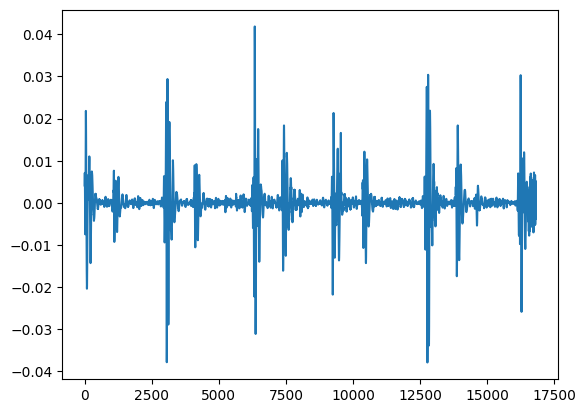

In [9]:
MIN_SECS = 4

filtered_segments = filter(lambda x: len(x) / digital_sample_rate > MIN_SECS, segments)
valid_segments = list(map(lambda x: x.unsqueeze(0), filtered_segments))

for i, segment in enumerate(valid_segments):
    segment = segment.squeeze()
    duration = len(segment) / digital_sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()

# All wrapped in one function

#1 (4.1s): tensor([0.4791, 0.4808, 0.4826,  ..., 0.4935, 0.4616, 0.4303])


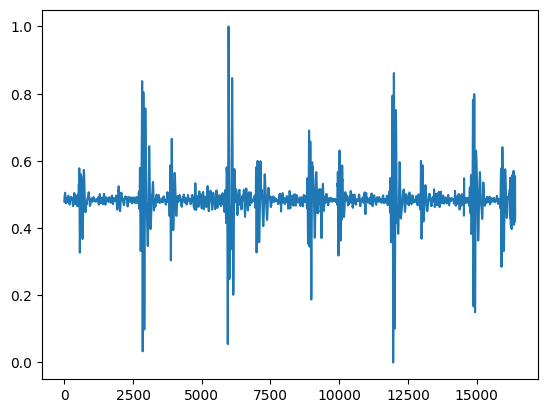

#2 (4.2s): tensor([0.5268, 0.5367, 0.5444,  ..., 0.5015, 0.4652, 0.4273])


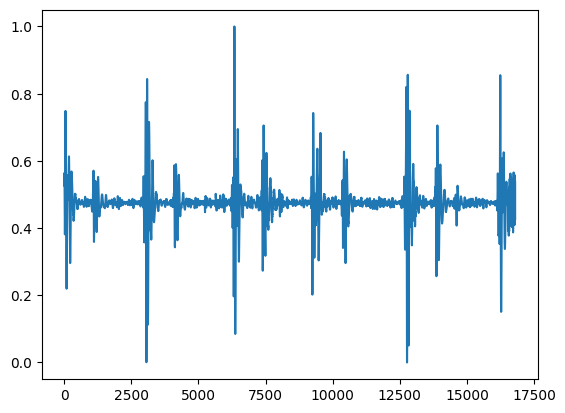

In [10]:
from helpers.transform import TrimAfterTrigger

tat = TrimAfterTrigger()

final_segments = tat.transform(
    audio_dir=DIGITAL_AUDIO_DIR,
    sample_rate_target=digital_sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    segment_min_duration=MIN_SECS,
)

for i, segment in enumerate(final_segments[0]):
    segment = segment.squeeze()
    duration = len(segment) / digital_sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()